# Modeling single-cell perturbation responses

Advances in single-cell experimental protocols allow measuring hundreds of thousands of cells under thousands of unique conditions {cite}`srivatsan2020` in massively multiplexed experiments. Recently, such technologies have been adapted to profile CRISPR-Cas9 with multimodal readouts level {cite}`Papalexi2021,frangieh2021`, {cite} genome-wide perturbations`replogle2021`, and {cite} combinatorial perturbations `wessels2022`. Despite experimental advances, exploring the massive perturbation space of combinatorial gene knock-outs or drug combinations remains challenging. The massive exploration space motivated the development of computational approaches for modeling single-cell perturbation responses  {cite} `ji2021`. Perturbation methods aim to predict transcriptomic response to stimuli, be it drugs, genetic knock-outs, or disease, for unseen populations where the perturbation response has not been measured. Multiple methods have been developed based on autoencoders{cite}`Lotfollahi 2019,2020,2021`, a deep learning framework to learn a low-dimensional representation of the data. Here, we demonstrate the application of  {cite} scGen `Lotfollahi 2019`, a variational autoencoder combined with vector arithmetics. The model learns a latent representation of the data in which it estimates a difference vector between control (untreated) and perturbed (treated) cells. The estimated difference vector is then added to control cells for the cell-type or population of interest to predict the gene expression response for each single cell. 

In [1]:
import logging
import scanpy as sc
import scgen

Global seed set to 0


### Loading the data

In [2]:
adata = sc.read("./kang_raw.h5ad",
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')

  0%|          | 0.00/22.4M [00:00<?, ?B/s]

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


This dataset contains PBMCs from eight patients with Lupus treated with IFN-β or left untreated from
{cite}`kang2018` across seven different cell-types.

In [7]:
adata.obs.cell_type.value_counts()

CD4T           5564
FCGR3A+Mono    3601
CD14+Mono      2561
B              1811
NK             1163
CD8T           1115
Dendritic      1078
Name: cell_type, dtype: int64

We remove CD4T cells from training data here since we later want to predict their response to IFN-β

In [46]:
adata_t = adata[~((adata.obs["cell_type"] == "CD4T") &
                    (adata.obs["condition"] == "stimulated"))].copy()

cd4t_stim = adata[((adata.obs["cell_type"] == "CD4T") &
                    (adata.obs["condition"] == "stimulated"))].copy()

Here we setup the the anndata

In [19]:
scgen.SCGEN.setup_anndata(adata_t, batch_key="condition", labels_key="cell_type")

### Model construction and training

In [20]:
model = scgen.SCGEN(adata_t)

model training 

In [22]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29/100:  29%|██▉       | 29/100 [01:48<04:25,  3.74s/it, loss=73.4, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 499.229. Signaling Trainer to stop.


To visualze the data, we plot the latent represeantion of the model 

In [25]:
adata_t.obsm["scgen"] = model.get_latent_representation()


In [28]:
sc.pp.neighbors(adata_t, use_rep="scgen")
sc.tl.umap(adata_t)

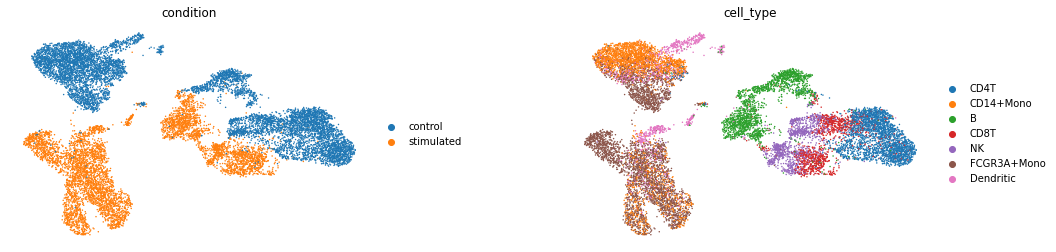

In [29]:
sc.pl.umap(adata_t, color=['condition', 'cell_type'], wspace=0.4, frameon=False)

As observed above, the IFN-β stimulation indcuced strong transcriptional changes across all cell-types 

### Predciting CD4T reponses to IFN-β

The model received control CD4T cells as input and return predicted gene expression response for each cell

In [42]:
# We feed 

pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)

pred.obs['condition'] = 'predicted stimulated'

/home/mo/miniconda3/envs/pytorch/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


### Evaluating single-cell perturbation responses

The evalution in this scenario is not challanging since we have access to ground truth CD4T cells after IFN-β

In [47]:
ctrl_adata = adata[((adata.obs['cell_type'] == 'CD4T') & (adata.obs['condition'] == 'control'))]
#concatenate pred, control and real CD4T cells in to one object
eval_adata = ctrl_adata.concatenate(cd4t_stim, pred)

In [48]:
eval_adata.obs.condition.value_counts()

stimulated              3127
control                 2437
predicted stimulated    2437
Name: condition, dtype: int64

We first look at the PCA co-embedding of control, IFN-β stimulated and predicted CD4T cells

... storing 'condition' as categorical


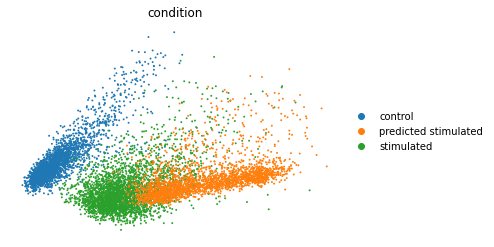

In [49]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False)

As observed above, the control cells were moved toward the CD4T stimulated cells with IFN-β. Yet we need to look at differentially expressed genes (DEGs). Bellow, we look at the overall mean correlation of predicted and real cells. Before that, we extract DEGs between control and stimulated cells:

In [53]:
cd4t_adata = adata[adata.obs["cell_type"] =="CD4T"]

In [55]:
sc.tl.rank_genes_groups(cd4t_adata, groupby="condition", method="wilcoxon")
diff_genes = cd4t_adata.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)

Trying to set attribute `.uns` of view, copying.


['ISG15' 'IFI6' 'ISG20' ... 'FTL' 'RGCC' 'FTH1']


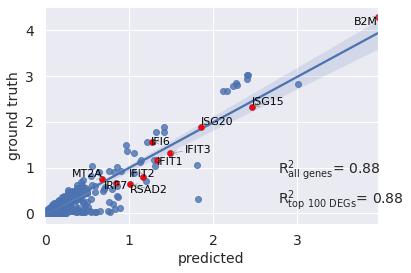

In [58]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "predicted stimulated", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes= diff_genes,
    labels={"x": "predicted","y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

We can addtionally look at distribution of top upregulated gene by IFN-β: 

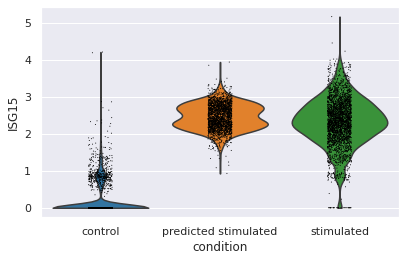

In [60]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")

The predicted cells can be further used to prioritize experiments in scenarios where a few samples are sparse or not measured.